In [0]:
import os
with open('tokens_and_api.txt', 'r') as file:
    exec(file.read())

#sas_token = tokens in tokens.txt
storage_account_name = "newadbprojektkakastorage"
container_name = "data"

spark.conf.set(
    f"fs.azure.account.auth.type.{storage_account_name}.dfs.core.windows.net", "SAS"
)
spark.conf.set(
    f"fs.azure.sas.token.provider.type.{storage_account_name}.dfs.core.windows.net",
    "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider"
)
spark.conf.set(
    f"fs.azure.sas.fixed.token.{storage_account_name}.dfs.core.windows.net",
    sas_token
)

base_path = f"abfss://{container_name}@{storage_account_name}.dfs.core.windows.net"
print(f"Skonfigurowano dostęp do: {base_path}")

Skonfigurowano dostęp do: abfss://data@newadbprojektkakastorage.dfs.core.windows.net


In [0]:
df_model = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(f"{base_path}/final_results/df_weather_jfk.csv")

display(df_model.limit(5))

DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DEPARTURE_DELAY,DISTANCE,CANCELLED,ORIGIN_AIRPORT,WEATHER_DELAY,ScheduledTimestamp,DeparturedTimestamp,HOURLYPrecip,HOURLYVISIBILITY,HOURLYWindSpeed
1,DL,2338,-3,1069,0,JFK,null,2015-01-05T16:00:00Z,2015-01-05T15:57:00Z,0.0,10.0,15.0
1,AA,67,9,1598,0,JFK,null,2015-01-05T16:05:00Z,2015-01-05T16:14:00Z,0.0,10.0,15.0
1,AA,65,5,1391,0,JFK,null,2015-01-05T16:15:00Z,2015-01-05T16:20:00Z,0.0,10.0,15.0
1,VX,27,2,2586,0,JFK,null,2015-01-05T16:30:00Z,2015-01-05T16:32:00Z,0.0,10.0,15.0
1,AA,133,0,2475,0,JFK,null,2015-01-05T16:30:00Z,2015-01-05T16:30:00Z,0.0,10.0,15.0


In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

#usuwamy kolumny czasowe/identyfikatory, zostawiamy parametry lotu i pogody
feature_cols = ["DISTANCE", "HOURLYVISIBILITY", "HOURLYWindSpeed", "DAY_OF_WEEK"]

#linie lotnicze (tekst na liczby)
airline_indexer = StringIndexer(inputCol="AIRLINE", outputCol="AIRLINE_INDEX", handleInvalid="skip")

#składanie cech w jeden wektor
assembler = VectorAssembler(inputCols=feature_cols + ["AIRLINE_INDEX"], outputCol="raw_features", handleInvalid="skip")

#skalowanie 
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=123)

rf_class = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features", numTrees=50)

#pipeline dla klasyfikacji
pipeline_class = Pipeline(stages=[airline_indexer, assembler, scaler, rf_class])
model_cancel = pipeline_class.fit(train_data)

#predykcja
predictions_cancel = model_cancel.transform(test_data)

#AUC - im bliżej 1, tym lepiej
evaluator_auc = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_cancel)

print(f"Skuteczność modelu (AUC) dla odwołań: {auc}")
display(predictions_cancel.select("CANCELLED", "prediction", "probability").limit(10))

Skuteczność modelu (AUC) dla odwołań: 0.9946198830409356


CANCELLED,prediction,probability
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.9998425696632295, 1.5743033677053945E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.9995425958982176, 4.574041017824057E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.9995425958982176, 4.574041017824057E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.999842475044368, 1.575249556320187E-4), vectorType -> dense)"
0,0.0,"Map(length -> 2, values -> List(0.9995425958982176, 4.574041017824057E-4), vectorType -> dense)"


In [0]:
display(predictions_cancel.filter((col("prediction") == 1) | (col("CANCELLED") == 1))
        .select("CANCELLED", "prediction", "probability"))

CANCELLED,prediction,probability
1,0.0,"Map(length -> 2, values -> List(0.9979509447254309, 0.002049055274569105), vectorType -> dense)"


In [0]:
predictions_cancel.groupBy("CANCELLED", "prediction").count().show()

+---------+----------+-----+
|CANCELLED|prediction|count|
+---------+----------+-----+
|        0|       0.0|12825|
|        1|       0.0|    1|
+---------+----------+-----+



In [0]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

df_reg = df_model.filter(col("CANCELLED") == 0)
train_reg, test_reg = df_reg.randomSplit([0.8, 0.2], seed=123)

gbt_reg = GBTRegressor(labelCol="DEPARTURE_DELAY", featuresCol="features", maxIter=20)

#pipeline dla regresji
pipeline_reg = Pipeline(stages=[airline_indexer, assembler, scaler, gbt_reg])
model_delay = pipeline_reg.fit(train_reg)

#predykcja
predictions_delay = model_delay.transform(test_reg)

#RMSE
evaluator_rmse = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions_delay)

print(f"Średni błąd przewidywania (RMSE): {rmse} minut")
display(predictions_delay.select("DEPARTURE_DELAY", "prediction").limit(10))

Średni błąd przewidywania (RMSE): 5.195487208727045 minut


DEPARTURE_DELAY,prediction
-6,-2.8135583020444463
-6,-2.891414167750666
-5,-2.8135583020444463
5,-2.52226078882262
-7,-3.6593851929929273
-6,-2.864223686678583
-3,-2.8135583020444463
-6,-2.795178608323851
-6,-2.8135583020444463
-3,-2.864223686678583


# Section with df_weather_jfk_cleaned

In [0]:
df_model_2 = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(f"{base_path}/final_results/df_weather_jfk.csv")

display(df_model_2.limit(5))

DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DEPARTURE_DELAY,DISTANCE,CANCELLED,ORIGIN_AIRPORT,WEATHER_DELAY,ScheduledTimestamp,DeparturedTimestamp,HOURLYPrecip,HOURLYVISIBILITY,HOURLYWindSpeed
1,DL,2338,-3,1069,0,JFK,null,2015-01-05T16:00:00Z,2015-01-05T15:57:00Z,0.0,10.0,15.0
1,AA,67,9,1598,0,JFK,null,2015-01-05T16:05:00Z,2015-01-05T16:14:00Z,0.0,10.0,15.0
1,AA,65,5,1391,0,JFK,null,2015-01-05T16:15:00Z,2015-01-05T16:20:00Z,0.0,10.0,15.0
1,VX,27,2,2586,0,JFK,null,2015-01-05T16:30:00Z,2015-01-05T16:32:00Z,0.0,10.0,15.0
1,AA,133,0,2475,0,JFK,null,2015-01-05T16:30:00Z,2015-01-05T16:30:00Z,0.0,10.0,15.0


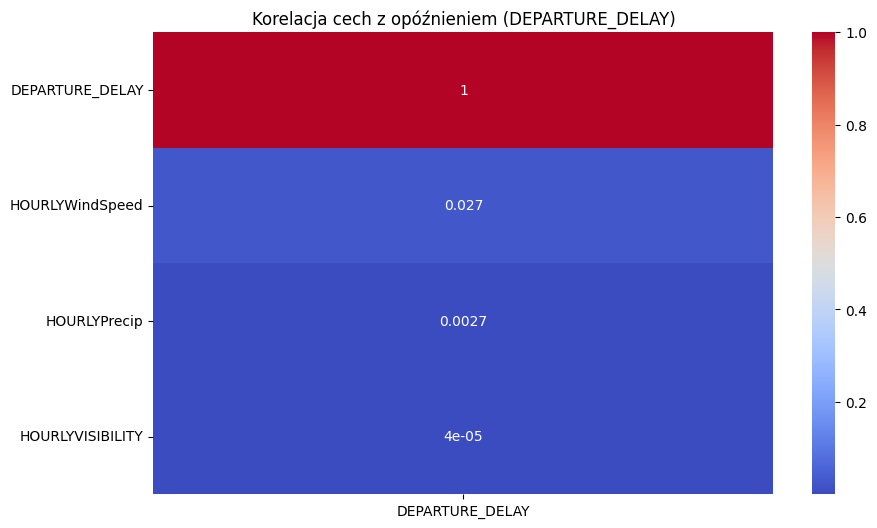

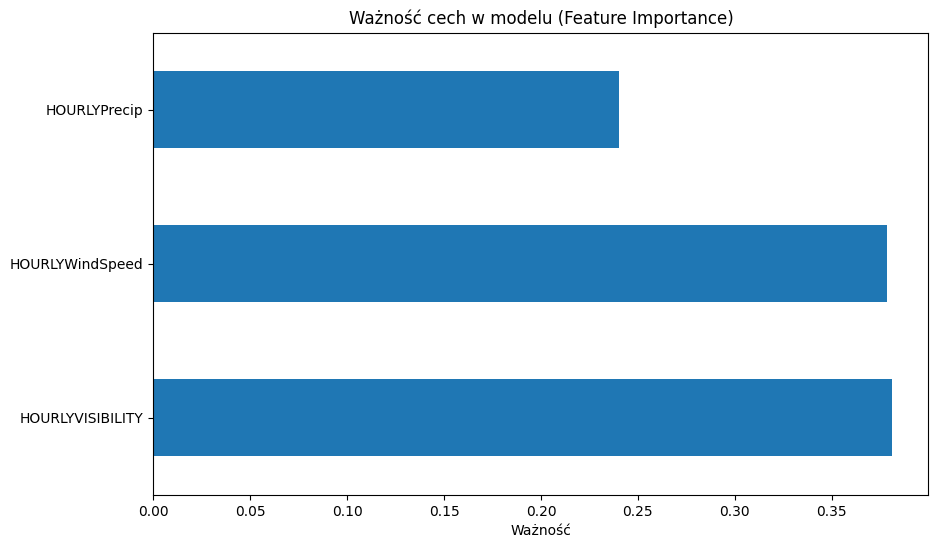

Dane po czyszczeniu (podgląd):
Row(DEPARTURE_DELAY=9, HOURLYPrecip=0.0, HOURLYVISIBILITY=10.0, HOURLYWindSpeed=15.0)

Statystyki modelu:
MSE: 24.25
R2: 0.03

Przewidywania vs Rzeczywistość:


Actual,Predicted
9,4.652408897325388
5,4.652408897325388
2,4.652408897325388
0,4.652408897325388
0,4.652408897325388
5,4.652408897325388
4,4.652408897325388
10,4.652408897325388
0,5.017160351941406
0,5.017160351941406


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pyspark.sql.functions import to_timestamp, hour, month

# Filter and drop columns using Spark DataFrame syntax
df = df_model_2.filter(df_model_2['DEPARTURE_DELAY'] >= 0)
cols_to_drop = ['FLIGHT_NUMBER', 'CANCELLED', 'WEATHER_DELAY', 'DeparturedTimestamp','ORIGIN_AIRPORT','FLIGHT_NUMBER','AIRLINE','DISTANCE','DAY_OF_WEEK']
df = df.drop(*cols_to_drop)

# Convert to timestamp and extract hour and month
df = df.withColumn('ScheduledTimestamp', to_timestamp('ScheduledTimestamp'))
df = df.drop('ScheduledTimestamp')

# Convert to pandas DataFrame for sklearn
df_pd = df.toPandas()

# One-hot encoding
df_pd = pd.get_dummies(
    df_pd,
    drop_first=True
)

plt.figure(figsize=(10, 6))
corr = df_pd.corr()
sns.heatmap(corr[['DEPARTURE_DELAY']].sort_values(by='DEPARTURE_DELAY', ascending=False), annot=True, cmap='coolwarm')
plt.title('Korelacja cech z opóźnieniem (DEPARTURE_DELAY)')

plt.show() 

X = df_pd.drop('DEPARTURE_DELAY', axis=1)
y = df_pd['DEPARTURE_DELAY']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# ==========================================
# Wizualizacja 2: Feature Importance
# ==========================================
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Ważność cech w modelu (Feature Importance)')
plt.xlabel('Ważność')
plt.show() 

print("Dane po czyszczeniu (podgląd):")
print(df.head())

print("\nStatystyki modelu:")
print(f"MSE: {mean_squared_error(y, y_pred):.2f}")
print(f"R2: {r2_score(y, y_pred):.2f}")

print("\nPrzewidywania vs Rzeczywistość:")
comparison = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

try:
    display(comparison)
except NameError:
    print(comparison)


In [0]:
display(df)

DEPARTURE_DELAY,HOURLYPrecip,HOURLYVISIBILITY,HOURLYWindSpeed
9,0.0,10.0,15.0
5,0.0,10.0,15.0
2,0.0,10.0,15.0
0,0.0,10.0,15.0
0,0.0,10.0,15.0
5,0.0,10.0,15.0
4,0.0,10.0,15.0
10,0.0,10.0,15.0
0,0.0,10.0,10.0
0,0.0,10.0,10.0


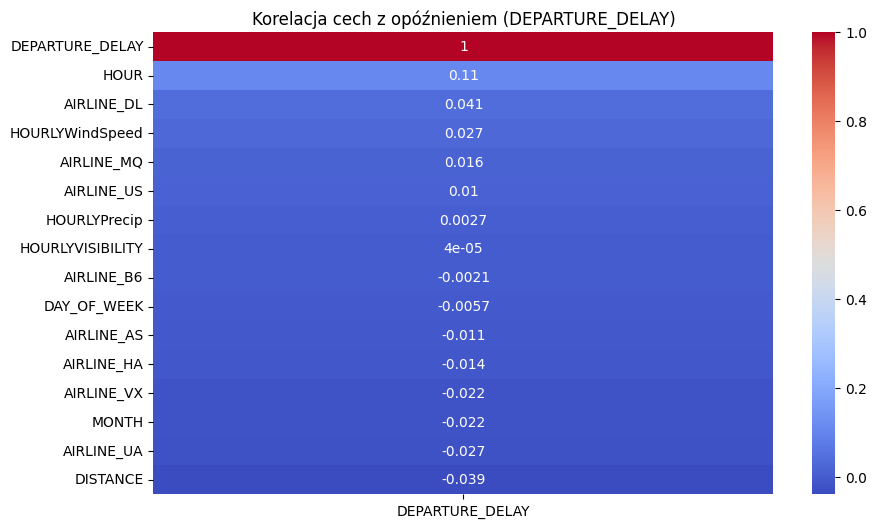

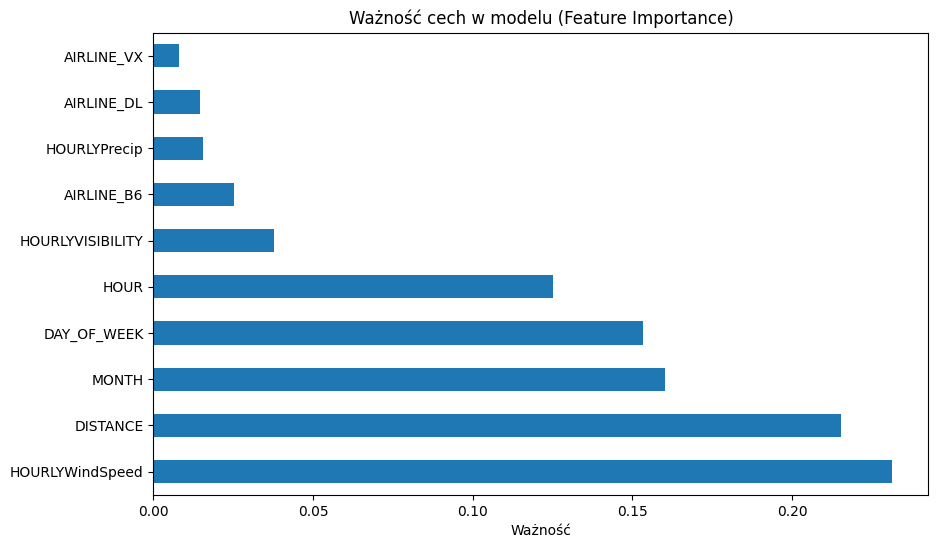

Dane po czyszczeniu (podgląd):
   DAY_OF_WEEK AIRLINE  DEPARTURE_DELAY  ...  HOURLYWindSpeed HOUR  MONTH
1            1      AA                9  ...             15.0   16      1
2            1      AA                5  ...             15.0   16      1
3            1      VX                2  ...             15.0   16      1
4            1      AA                0  ...             15.0   16      1
6            1      B6                0  ...             15.0   16      1

[5 rows x 10 columns]

Statystyki modelu:
MSE: 4.17
R2: 0.83

Przewidywania vs Rzeczywistość:


Actual,Predicted
9,7.89
5,4.275
2,2.47
0,2.6
0,2.6166666666666663
5,4.67
4,3.49
10,9.065
0,1.4635000000000002
0,1.65


In [0]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


df_pandas = df_model_2.toPandas()

# Zostawienie tylko delay >= 0
df_cleaned = df_pandas[df_pandas['DEPARTURE_DELAY'] >= 0].copy()

# Usuwanie zbędnych kolumn
columns_to_drop = ['FLIGHT_NUMBER', 'CANCELLED', 'WEATHER_DELAY', 'DeparturedTimestamp']

df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

df_cleaned['ScheduledTimestamp'] = pd.to_datetime(df_cleaned['ScheduledTimestamp'])
df_cleaned['HOUR'] = df_cleaned['ScheduledTimestamp'].dt.hour
df_cleaned['MONTH'] = df_cleaned['ScheduledTimestamp'].dt.month
df_cleaned = df_cleaned.drop(columns=['ScheduledTimestamp'])

# Kodowanie zmiennych kategorycznych (One-Hot Encoding)
df_model = pd.get_dummies(df_cleaned, columns=['AIRLINE', 'ORIGIN_AIRPORT'], drop_first=True)

# ==========================================
# Wizualizacja 1: Korelacja
# ==========================================
plt.figure(figsize=(10, 6))
corr = df_model.corr()
sns.heatmap(corr[['DEPARTURE_DELAY']].sort_values(by='DEPARTURE_DELAY', ascending=False), annot=True, cmap='coolwarm')
plt.title('Korelacja cech z opóźnieniem (DEPARTURE_DELAY)')

plt.show() 

# Trenowanie modelu
X = df_model.drop('DEPARTURE_DELAY', axis=1)
y = df_model['DEPARTURE_DELAY']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

# 4. Ewaluacja i Ważność cech
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# ==========================================
# Wizualizacja 2: Feature Importance
# ==========================================
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Ważność cech w modelu (Feature Importance)')
plt.xlabel('Ważność')
plt.show() 
print("Dane po czyszczeniu (podgląd):")
print(df_cleaned.head())

print("\nStatystyki modelu:")
print(f"MSE: {mean_squared_error(y, y_pred):.2f}")
print(f"R2: {r2_score(y, y_pred):.2f}")

print("\nPrzewidywania vs Rzeczywistość:")
comparison = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

try:
    display(comparison)
except NameError:
    print(comparison)